This is the time of year when even thinking about flowers makes my eyes water. 
While it doesn't completely stop me from enjoying the outdoors, I find forecasts useful for planning and setting expectations. 

There are pollen tracking services that I find useful, but have shortcomings in their coverage in time or granularity. Some don't measure pollen on the weekends, when I'm most likely to be out, and some just give an aggregated count, ignoring the more relevant tree pollen count I'm interested in. This gap left me wondering how far I could get predicting pollen levels from the weather on my own, and looked like an opportunity to apply my recent interest in deep learning models, and RNNs in particular.

In [1]:
from imports import *
# %mkdir cache
import joblib; mem = joblib.Memory(cachedir='cache')

%matplotlib inline

In [2]:
from util.pollen_utils import pscale
import util.utils; reload(util.utils); from util.utils import (
    check_one2one, yrmths, flatten_multindex, ends_with,
    BatchArray, ravel, repackage_hidden, mse,
    replace_with_dummies,  filter_dtypes, log_,
    join_pollen_weather, read
)

date = lambda xs: dt.datetime(*xs)

## The training data 
For the forecasting model to be useful for me, it needs to be trained on data that will be available when I need to make prediction.

If I want to know tomorrow's pollen levels and I have a summary of today's weather available, then it will be enough to train the model on pollen counts using weather data from the previous day. The problem is simpler if I simply want an estimate of today's count based on today's weather (say it's the weekend, when the regular source is unavailable), in which case the input and output of the training data are aligned to the same day. Another variation would be to train on historical _forecasts_ of the data, since this would give longer range estimates and would allow for more flexibility in use cases. 

For this first iteration of the model I decided to train on daily weather summaries from Dark Sky as the inputs, and same-day pollen counts as the output, due to the ease in accessing the data. This is suboptimal for many use cases, but can at least be a start for a ballpark estimate of expected model performance. (The code for pulling this data is in the data-fetcher.ipynb notebook)

In addition to the weather data, I used different date fields (for example, month number and day of the year) and the previous day's pollen count, which turns out to be super correlated with today's pollen count (almost 90%).

In [3]:
dailydf = feather.read_dataframe('cache/dark_day.fth')

dailydf = (
    dailydf.sort_values('Time', ascending=True).reset_index(drop=1)
    .assign(Dt=lambda x: pd.to_datetime(x.Time, unit='s'))
    .assign(
        Day=lambda x: x.Dt.dt.day,
        Doy=lambda x: x.Dt.dt.dayofyear,
        M=lambda x: x.Dt.dt.month,
        Y=lambda x: x.Dt.dt.year,
        Day_int=lambda x: (x['Dt'] - x['Dt'].min()).dt.days,
    )
    .drop('Ozone', axis=1)  # This is a new field, I guess
)

Here's a sample of the daily weather data:

In [4]:
dailydf[:3]

   Apparent_temperature_max  Apparent_temperature_max_time  Apparent_temperature_min  Apparent_temperature_min_time  \
0                     97.40                      712263600                     74.12                      712234800   
1                     87.95                      712360800                     72.47                      712321200   
2                     93.64                      712447200                     69.01                      712404000   

   Cloud_cover  Dew_point  Humidity               Icon  Moon_phase  Precip_accumulation  Precip_intensity  \
0         0.59      73.40      0.83               rain        0.92                  NaN            0.0164   
1         0.72      69.63      0.78  partly-cloudy-day        0.96                  NaN            0.0022   
2         0.47      69.11      0.73  partly-cloudy-day        0.99                  NaN            0.0000   

   Precip_intensity_max  Precip_intensity_max_time  Precip_probability Precip_type  Pr

# Nulls
I've yet to find perfectly clean dataset that's ready to use out of the box, and this is no exception. While better than some weather data sources I tried, it still has some columns with nulls that we'll have to deal with. Some are straightforward, like `Precip_type` and `Precip_accumulation`:

In [5]:
dailydf.loc[dailydf.eval('Precip_type != Precip_type'), 'Precip_type'] = 'none'
dailydf['Precip_accumulation'] = dailydf.Precip_accumulation.fillna(0)

For the field that records the time of day with the maximum precipitation, I just filled in the missing values (for days when it didn't rain) with the minimum time of the day:


In [6]:
def fill_pimt_null(s, timecol):
    """This column is null when there is no precipitation.
    Not sure of anything better to do, so I'm just setting
    it to the minimum time of the day in question
    """
    s2 = s.copy()
    null_ptime = s.isnull()
    s2.loc[null_ptime] = timecol[null_ptime]
    return s2.astype(int)

dailydf['Min_time'] = dailydf.Dt.map(lambda t: int(t.replace(hour=0).strftime('%s')))
dailydf.Precip_intensity_max_time = fill_pimt_null(dailydf.Precip_intensity_max_time, dailydf.Min_time)

The nulls in the cloud cover were a bit trickier to tease out. Throwing it through a decision tree didn't reveal any obvious rules for when nulls would occur, so I just built a quick random forest model to use the other features to determine what should go in the missing rows for `Cloud_cover`. The predictions from this imputation model on held out data shows a pretty good correlation with the actual values:

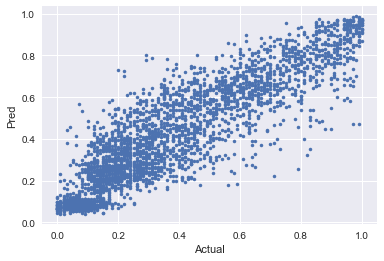

In [7]:
from IPython.display import Image
Image('plots/cloud_cover_model_perf.png', height=400, width=400)

so I went ahead and stuck with it. The nulls don't appear to be randomly distributed, however (they seemed to be correlated with snow and visibility), so it may be worthwhile to look for a better way to deal with them some other time. 

In [8]:
from sklearn.ensemble import RandomForestRegressor

def fill_cloud_cover_null(cc, X):
    """Solution wasn't obvious, so I just imputed the nulls
    with a random forest using the other columns.
    """
    null = cc != cc
    if not null.any():
        return cc

    rf = RandomForestRegressor(n_estimators=30, oob_score=True)
    rf.fit(X[~null], cc[~null])
    cc2 = cc.copy()
    cc2.loc[null] = rf.predict(X[null])
    return cc2


_feats = [k for k, d in dailydf.dtypes.items()
      if (d == float or d == int) and (k != 'Cloud_cover')
]
dailydf['Cloud_cover'] = fill_cloud_cover_null(dailydf.Cloud_cover, dailydf[_feats])

### Check times
In addition to replacing the text categorical variables with dummy values, I also adjusted the time attributes (sunrise, sunset, maximum temperature &c) so that they reflected time of the day rather than UNIX time.

In [9]:
ddf = replace_with_dummies(dailydf, 'Icon Precip_type'.split())
assert (ddf == ddf).all().all(), "Don't want nulls here"

In [10]:
# Check that within a day the difference between maximum
# and minimum times are not greater than the
# number of seconds in a day

times = lfilter(lambda x: x.endswith('ime'), ddf)
minmax = DataFrame({
    'Min': ddf[times].min(axis=1),
    'Max': ddf[times].max(axis=1),
}).assign(Diff=lambda x: x.Max.sub(x.Min).div(60 * 60 * 24)) 

assert 0 <= minmax.Diff.max() <= 1, "All times within a day should be no more than 24 hrs apart"
minmax.Diff.max()  # should be no more than 1

1.0

In [11]:
assert (ddf[times].min(axis=1) == ddf.Min_time).all(), 'By definition'

In [12]:
unix_time_to_day_hrs = lambda s, min_time: (s - min_time) / 3600

for t in set(times) - {'Min_time'}:
    c = t + 's'
    ddf[c] = unix_time_to_day_hrs(ddf[t], ddf.Min_time)

Some cols now have a single value. Drop them.

In [13]:
slen = lambda x: len(set(x))
nunique = ddf.apply(slen)
ddf = ddf[nunique[nunique > 1].index].copy()

### Pollen
From personal experience, the symptoms have a nonlinear response rate to the pollen count that is mirrored in the [NAB](http://www.aaaai.org/global/nab-pollen-counts/reading-the-charts) classification. Here's the scale:

In [14]:
pscale

     Count      Level
0        0     Absent
1     1-14        Low
2    15-89   Moderate
3  90-1499       High
4    1500+  Very High

Since the symptoms increase with each order of magnitude change in the count, rather than by a constant, this tells me the target would be well modeled by the log of the pollen count. The standard MSE would penalize a prediction that's off by 50 the same, regardless of whether the actual count is in the low or high range, but modeling the log of the count would improve the metric.

The plot below shows what I mean. The raw plot on the left shows a more drastically varying scale, which would be trickier to learn with a simple MSE loss, compared to the more evenly scaled log plot on the right.

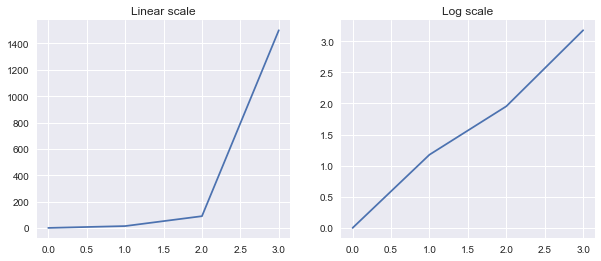

In [15]:
_, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))

cutoffs = np.array([1, 15, 90, 1500])
ax1.set_title('Linear scale')
ax1.plot(cutoffs)

ax2.set_title('Log scale')
ax2.plot(np.log10(cutoffs));

### Weather & pollen become one
This is where weather in pollen tables are joined, the target variable is logified, features are standardized, and data is wrapped in torch variables. You can see `utils.join_pollen_weather` if such things do not bore you.

I'm pretty sure that not every variable that is helpful and many convey redundant information, but since I haven't seen the straightforward way to do feature selection with deep networks, I'll have to save that part for another day.

In [16]:
poldf = feather.read_dataframe('cache/pollen.fth')

xdf, xt, yt, rx, rxdf, ry = join_pollen_weather(
    poldf, ddf, time_cols=times, ycol='Logcnt'
)

/Users/williambeard/Dropbox/dev/blog_projects/pollen/util/utils.py:316: RuntimeWarning: divide by zero encountered in log10
  lg = np.log10(s)


In [17]:
print('|X|:', xt.size())
print('|y|:', yt.size())

print("Pollen count's 1st lag auto-correlation: {:.2%}"
      .format(xdf.Logcnt.corr(xdf.Logcnt.shift())))

# Sanity check that it's ordered ascending my date and not null
assert xdf.Dt.is_monotonic_increasing
assert xdf.Time.is_monotonic_increasing
assert (xdf.Doy > xdf.Doy.shift(1)).mean() > .98, (
    "Day of year int should increase once a year")

assert not xdf.isnull().any().any()

|X|: torch.Size([4437, 39])
|y|: torch.Size([4437, 1])
Pollen count's 1st lag auto-correlation: 87.23%


Sanity check that I didn't accidentally include a transformation of target variable in the predictors:

In [18]:
corrs = (rxdf.corrwith(ry).to_frame().rename(columns={0: 'Corr'})
         .assign(Abs=lambda x: x.Corr.abs())
         .sort_values('Abs', ascending=0).Corr)
assert corrs.abs().max() < .9
corrs[:5]

Log_prev_cnt    0.872299
Doy            -0.399720
M              -0.398627
Sunset_times    0.343262
Humidity       -0.203511
Name: Corr, dtype: float64

## RNN
While a standard model that works on tabular data could work (think linear regression, KNN, GBMs) their standard usage doesn't take into account the sequential structure of the data, and ignores useful information. There are more classical models that take the sequential structure into account, like HMMs and Kalman filters,
but since I'm going through a phase of aiming deep learning solutions at problems, a recurrent neural network is the favored choice. While different in many ways from an HMM, it does share the element of hidden variables that track state over time, even if they don't convey the kind of useful probabilistic information that an HMM's hidden states would.

There are roughly a gajillion deep learning frameworks around these days, but I went with [Pytorch](http://pytorch.org/) because it looked fun.

In [19]:
import torch as T
from torch.autograd import Variable
from torch import optim
from torch import nn

tofloat = lambda x: x.data[0]
unvar = lambda x: x.data.numpy().ravel()

And here is the main model. It basically uses an RNN with GRUs (a simplified version of the standard LSTM cell, named after a data science twitter celebrity), with the output units leading to a dense layer after a dropout layer

In [20]:
class Rnn(nn.Module):
    def __init__(self, P=3, nhidden=21, num_layers=1, dropout=0):
        super().__init__()
        self.P, self.nhidden, self.num_layers, self.dropout = (
            P, nhidden, num_layers, dropout
        )
        self.rnn = nn.GRU(P, nhidden, num_layers, batch_first=True, dropout=dropout)
        self.Dropout = nn.Dropout(p=dropout)
        self.decoder = nn.Linear(nhidden, 1)
        self.init_weights()
        self.zero_grad()

    def __dir__(self):
        return super().__dir__() + list(self._modules)
    
    def forward(self, input, hidden=None, outputh=False):
        if hidden is None:
            hidden = self.hidden
        out1, hout = self.rnn(input, hidden)
        out1d = self.Dropout(out1)
        out2 = self.decoder(ravel(out1d))
        self.hidden = repackage_hidden(hout)  # don't waste time tracking the grad
        if outputh:
            return out2, hout
        return out2
        
    def init_weights(self):
        initrange = 0.1
        for p in self.rnn.parameters():
            xavier_init(p.data)
        self.decoder.bias.data.fill_(0)
        xavier_init(self.decoder.weight.data)

    def init_hidden(self, bsz):
        "For lstm I'll need to return 2"
        weight = next(self.rnn.parameters()).data
        mkvar = lambda: Variable(weight.new(self.num_layers, bsz, self.nhidden).zero_())
        return mkvar()
    
    def set_hidden(self, bsz):
        h = self.init_hidden(bsz)
        self.hidden = h
        
        
def xavier_init(t):
    "This seems to be the recommended distribution for weight initialization"
    n = max(t.size())
    return t.normal_(std=n ** -.5)

criterion = nn.MSELoss()

The training routine is pretty standard and self explanatory:

In [21]:
def train_epoch(barray, model=None, hidden=None, optimizer=None, eval=False, batch_size=None):
    batch_size = batch_size or barray.batch_size
    assert batch_size or hidden
    hidden = model.init_hidden(batch_size) if hidden is None else hidden
    
    res = []
    ss, n = 0, 0

    for bix in barray.batch_ix_iter(batch_size=batch_size):
        x, y = barray[bix]
        optimizer.zero_grad()
        output = model(x, hidden)
        
        res.append(output.data.squeeze())
        if eval:
            continue

        loss = criterion(output, y.view(-1, 1))
        loss.backward()

        T.nn.utils.clip_grad_norm(model.parameters(), 3)
        optimizer.step()
        
        ss += tofloat(loss) * len(output)  # keep track of ss
        n += len(output)

    res = T.stack(res).view(-1).numpy()
    if eval:
        return res
    tot_loss = ss / n
    return tot_loss, res

When I want to make a prediction on the validation set, I first run the model over a few preceding examples to update the hidden weights, since the validation set is relatively small (that is, with `warmup=True` in `val_pred`):

In [22]:
def val_pred(model, warmup=True):
    if warmup:
        model.set_hidden(1)

    ix = int(not warmup)
    Dt = baval.Dt[ix]
    xs, ysv = baval[[ix]]

    ys = Series(unvar(ysv), index=Dt)
    yspred = model(xs)

    yspred_s = Series(unvar(yspred), index=Dt)
    return yspred_s, ys

And here are the functions to run the training routines and log the progress

In [23]:
# %mkdir /tmp/res/
VALFN = '/tmp/res/val.txt'
TRNFN = '/tmp/res/trn.txt'

def report_hook(model, res, vals=None):
    print()
    val_pred(model, warmup=True)
    yspred, ys = val_pred(model, warmup=False)
    val_acc = mse(yspred, ys)
    vals.append(val_acc)
    trn_acc = mse(ba.train_samples_y, res)

    with open(VALFN, 'a') as f:
        f.write('{:}\n'.format(val_acc))
    with open(TRNFN, 'a') as f:
        f.write('{:}\n'.format(trn_acc))
    print('{:,.3f}; val: {:,.4f}'.format(trn_acc, val_acc), end='; ')

    
def train_epochs(model, optimizer=None, rng=(500, ), print_every=10, report_hook=None, report_kw={}):
    with open(VALFN, 'w') as f: pass
    with open(TRNFN, 'w') as f: pass
    vals = []
    
    for i in range(*rng):
        _, res = train_epoch(ba, model=model, hidden=None, optimizer=optimizer)

        print('.', end='')
        if i % print_every == 0:
            if report_hook:
                report_hook(model, res, vals=vals)
        
    return res, min(vals)

## Training and Model parameters

A lot of standard tips for RNN settings didn't seem to apply to this problem, since approximately 100% of the use cases I see are for NLP tasks. For one, I have a lot less data, so the batch size remainders matter more. Using a batch size of 32 and sequence length of 25, I use all the full batches for the training set (4000 samples), and the remaining samples (~400) for the validation set.

I also found that fewer hidden units worked pretty well. For some settings, 128 units was overkill, and completely overfit the data, though using just 8 served as a decent form of regularization. I settled on a higher number of units for reasons explained later, but dropout helped prevent overfitting.

I used [skopt's](https://scikit-optimize.github.io/) Gaussian process optimizer to find a good set of hyperparameters.

In [24]:
# training batches
seq_len = 25
bcz = 32
ba = BatchArray(x=xt, y=yt, seq_len=seq_len, batch_size=bcz)

# validation batches
l = ba.num_leftover_rows
baval = BatchArray(x=xt[-2 * l:], y=yt[-2 * l:], seq_len=l, batch_size=1)

assert (xdf.index == rxdf.index).all(), 'Dropped some nulls?'
baval.Dt = [xdf.Dt.iloc[-2*l:-l], xdf.Dt.iloc[-l:]]
print('Training size: {}\nValidation size: {}'.format(ba.num_truncated_rows, l))

Training size: 4000
Validation size: 437


In [25]:
nhidden = 128
num_layers = 2
model = Rnn(P=rx.shape[-1], nhidden=nhidden, num_layers=num_layers, dropout=.05)
model.set_hidden(bcz)

optimizer = optim.Adam(model.parameters(), lr = 0.001)
model

Rnn (
  (rnn): GRU(39, 128, num_layers=2, batch_first=True, dropout=0.05)
  (Dropout): Dropout (p = 0.05)
  (decoder): Linear (128 -> 1)
)

With these settings, the loss plot below shows that the validation score doesn't improve much after about 20 epochs

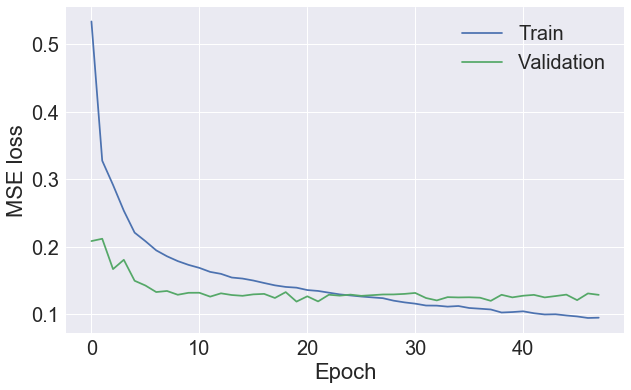

In [26]:
Image('plots/valid.png')

In [27]:
st = time.perf_counter()
res, mvals = train_epochs(model=model, optimizer=optimizer, rng=(25, ), print_every=10, report_hook=report_hook)
tt = time.perf_counter() - st

print('\n\nTime: {:.2f}'.format(tt))
print('Acc: {:.2f}; Val: {:.3f}'.format(mse(res, ba.train_samples_y), mvals))

.
1.604; val: 1.3273; ..........
0.183; val: 0.1415; ..........
0.142; val: 0.1295; ....

Time: 8.07
Acc: 0.13; Val: 0.130


## Results...with uncertainty

Although they use probabilistic activations within the cells, RNNs aren't usually chosen for quantifying the uncertainty of their predictions. Being a Bayesian, this makes me want to wash my hands, but it also makes RNNs a lot less useful for forecasting than other methods when you have no idea what the model's confidence is in its predictions.

A [fascinating blog post by Yarin Gal](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html), however, draws a connection between deep networks using dropout and Gaussian processes, with a simple formula to provide probabilistic uncertainty estimates for fully connected layers with dropout. While I'm not sure (in fact, quite doubtful) that the exact equations transfer to RNNs, I was curious about the results using dropout to simulate variation in the prediction. 

In [28]:
(x_warm, y_warm) = baval[0]
(x_val, y_val) = baval[1]
y_val = y_val.data.numpy().ravel()

x_warm = x_warm.unsqueeze(0)
x_val = x_val.unsqueeze(0)

In [29]:
def eval_val(model, x_val):
    model(x_warm)
    val_pred = model(x_val).data  #.numpy().ravel()
    return val_pred

model.set_hidden(1)

Here I get simulated results on the held out data

In [30]:
%%time
# ressv = np.array([eval_val(model, x_val) for _ in range(100)])
ressv = T.cat([eval_val(model, x_val) for _ in range(100)], 1).numpy()

CPU times: user 2min 13s, sys: 7.44 s, total: 2min 20s
Wall time: 43.4 s


and calculate the mean and variance

In [31]:
mu = ressv.mean(axis=1)
var = ressv.var(axis=1)

lparam = 50
tau = lparam**2 * (1 - model.dropout) / (2 * l * .9)
var += tau**-1

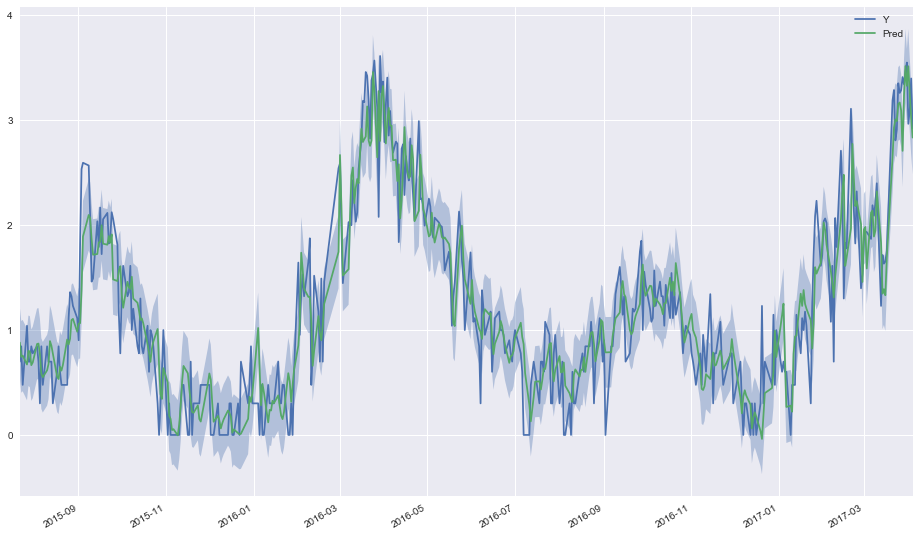

In [32]:
plt.figure(figsize=(16, 10))
dates = xdf.Dt[-l:].values
datify = lambda x: Series(x, index=dates)

datify(y_val).plot()
datify(mu).plot()

plt.legend(['Y', 'Pred'])

lo = datify(mu - var)
hi = datify(mu + var)
plt.fill_between(dates, lo, hi, alpha=.35, edgecolor='none')

### Errors

To my eye, it looks like the predictions track the held out values pretty nicely, though they look like they have something of a smoothing effect when the actual values jump around a lot. Looking at the residuals show that the error is higher when the pollen count jumps a lot from day to day:

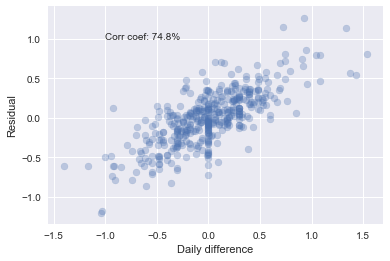

In [33]:
resid = y_val - mu
diffy = y_val[1:] - y_val[:-1]
# diffpred = mu[1:] - mu[:-1]

plt.scatter(diffy, resid[1:], alpha=.3)
plt.xlabel('Daily difference')
plt.ylabel('Residual')
plt.text(-1, 1, 'Corr coef: {:.1%}'.format(np.corrcoef(diffy, resid[1:])[0][1]));

Since the pollen counts are so highly correlated with the count of the previous day, I thought that on weekends or other days with missing counts could be associated with the big jumps, that tend to have the highest error. I even included the number of skips days in the model as `Day_diff`, but this seems to have almost relation with the errors (see the left plot).

My other thought was that the amount of uncertainty in the simulated results should also increase around these big changes, and therefore around the residuals. Sadly, the model didn't learn this, and the variance looks completely uncorrelated with the residuals (on the right).

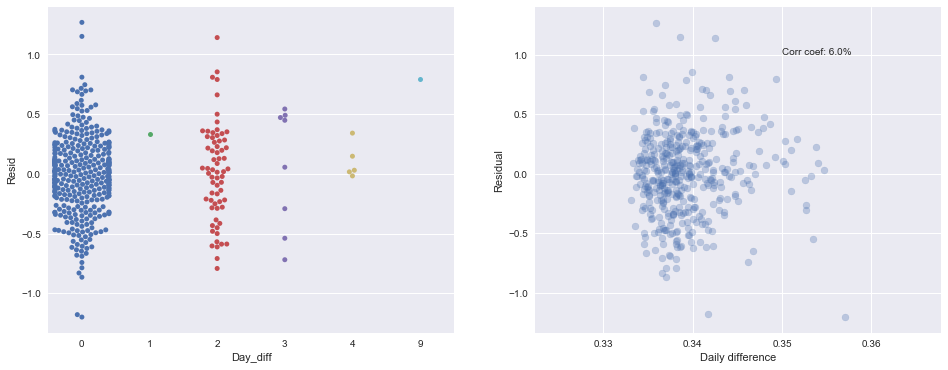

In [34]:
_, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 6))

sns.swarmplot(data=rxdf[-l:].assign(Resid=resid), x='Day_diff', y='Resid', ax=ax1)

# uncert_diff = (m9 - m10)[1:]
uncert_diff = var[1:]
ax2.scatter(uncert_diff, resid[1:], alpha=.3)
plt.xlabel('Daily difference')
plt.ylabel('Residual')
plt.text(.35, 1, 'Corr coef: {:.1%}'.format(np.corrcoef(uncert_diff, resid[1:])[0][1]));

Overall I'm pretty happy in the RNN's ability to capture the dynamics of the weather and make pollen count predictions. Some improvements I would be interested in making, would be to give the model a better idea of when to be less confident. Because of the suspected feature information redundancy, it would also be worthwhile to look into applying feature selection to the model. But all in all this looks like a good start to a making a useful personalized pollen forecasting system. 